In [1]:
import cv2
import numpy as np

%matplotlib -l
%matplotlib inline
from matplotlib import pyplot as plt

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


(512, 768)


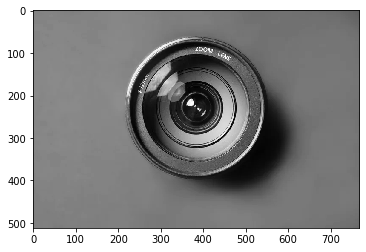

In [2]:
im = cv2.imread('/Volumes/RAMDisk/lens.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print (im.shape)
sz = im.shape

plt.figure()
plt.imshow(im, cmap='gray')

[[  0.87758256   0.47942554 -46.91813248]
 [ -0.47942554   0.87758256 216.25370306]
 [  0.           0.           1.        ]]


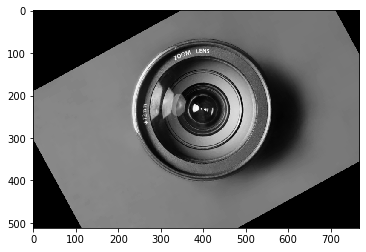

In [15]:
T_pos1000 = np.array([
    [1, 0, 400],
    [0, 1, 200],
    [0, 0, 1]])
# rotate - opposite angle
th = .5
T_rotate = np.array([
    [np.cos(th), np.sin(th), 0],
    [-np.sin(th), np.cos(th), 0],
    [0, 0, 1]])
# scale
T_scale = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1]])
# center original to 0,0
T_neg500 = np.array([
    [1, 0, -400],
    [0, 1, -200],
    [0, 0, 1]])
T = T_pos1000 @ T_rotate @ T_scale @ T_neg500 
#T = np.array([[1,0,3],
#              [0,1,5],
#              [0,0,1]])
print (T)
T_opencv = np.float32(T.flatten()[:6].reshape(2,3))
im_transformed = cv2.warpAffine(im, T_opencv, (sz[1], sz[0]))
plt.imshow(im_transformed, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


177.83112

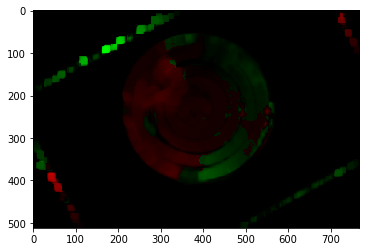

In [43]:

hsv = np.zeros(sz+(3,))

flow = cv2.calcOpticalFlowFarneback(im,im_transformed,None, 
                                    pyr_scale=0.5, 
                                    levels=5, 
                                    winsize=15, 
                                    iterations=3, 
                                    poly_n=9, 
                                    poly_sigma=1.5, flags=0)
#                                   None, 0.5, 5, 15, 3, 5, 1.5, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,1] = 255
hsv[...,2] = cv2.normalize(mag,None,0,1,cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv.astype(np.float32),cv2.COLOR_HSV2RGB)
plt.imshow(bgr)
np.max(flow)

(512, 768)


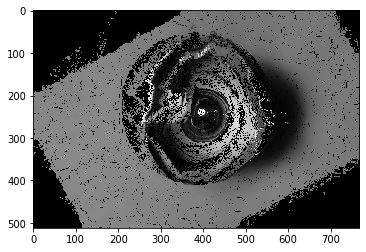

In [44]:
im_out = np.zeros(sz, dtype=np.float32)
print (im_out.shape)
for i in range(sz[0]):
    for j in range(sz[1]):
        i1 = int(i+flow[i,j,0])
        j1 = int(j+flow[i,j,1])
        if i1>=0 and j1>=0 and i1<sz[0] and j1<sz[1]:
            im_out[i1][j1] = im_transformed[i,j]
plt.imshow(im_out,  cmap='gray')


In [45]:
select = np.where((flow[...,0] + flow[...,1]).flatten()>.1)

ys, xs = np.meshgrid(range(sz[0]), range(sz[1]), indexing='ij')
ys1 = ys+flow[...,0]
xs1 = xs+flow[...,1]
ys = ys.flatten()[select]
xs = xs.flatten()[select]
ys1 = ys1.flatten()[select]
xs1 = xs1.flatten()[select]
Mx = np.vstack([xs, ys, np.ones(len(xs)).T]).T
bx = xs1
My = np.vstack([xs, ys, np.ones(len(xs)).T]).T
by = ys1
ax = np.linalg.inv(Mx.T @ Mx) @ Mx.T @ bx
ay = np.linalg.inv(My.T @ My) @ My.T @ by
H = np.vstack([ax, ay, [0,0,1]])
print (H)

#coords = np.vstack([xs, ys]).T
#coords1 = np.vstack([xs1, ys1]).T
#M = cv2.getAffineTransform(coords, coords1)
#print (M)


[[ 9.69795929e-01 -3.97301725e-03  1.95993552e+01]
 [-1.55044618e-02  1.02692396e+00  1.53878994e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


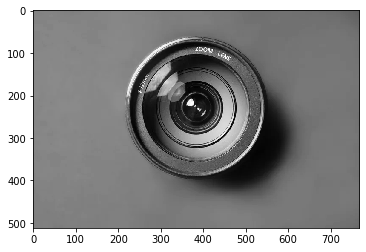

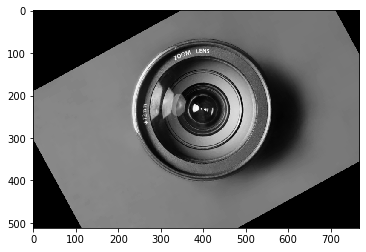

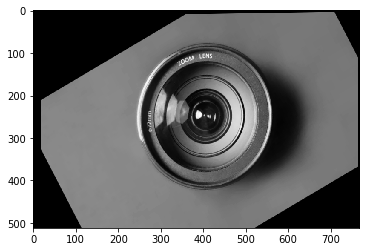

In [52]:

im_out = cv2.warpAffine(im_transformed,H[:2,:],(sz[1],sz[0]))
plt.imshow(im,  cmap='gray')
plt.figure()
plt.imshow(im_transformed,  cmap='gray')
plt.figure()
plt.imshow(im_out,  cmap='gray')
